# `Grid` example

In this example we load a HDF5 (test) grid file into a corresponding `Grid` object, and use the inbuilt functionality to explore the grid.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from synthesizer.grid import Grid

This object takes the location of the grids on your system (`grid_dir`) and the name of the grid you wish to load `grid_name`). Here we load a simple test grid provided with the module (hence the relative path).

In [3]:
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"

grid = Grid(grid_name, grid_dir=grid_dir)
print(grid)

+------------------------------------------------------------------------------------------------+
|                                              GRID                                              |
+-----------------------------+------------------------------------------------------------------+
| Attribute                   | Value                                                            |
+-----------------------------+------------------------------------------------------------------+
| grid_dir                    | '../../../tests/test_grid'                                       |
+-----------------------------+------------------------------------------------------------------+
| grid_name                   | 'test_grid'                                                      |
+-----------------------------+------------------------------------------------------------------+
| grid_ext                    | 'hdf5'                                                           |
+---------

A `Grid` can also take various arguments to limit the size of the grid, e.g. by isolating the `Grid` to a wavelength region of interest. This is particularly useful when making a large number of spectra from a high resolution `Grid`, where the memory footprint can become large.

### Passing a wavelength array

If you only care about a grid of specific wavelength values, you can pass this array and the `Grid` will automatically be interpolated onto the new wavelength array using [spectres](https://github.com/ACCarnall/SpectRes):

In [4]:
# Define a new set of wavelengths
new_lams = np.logspace(2, 5, 1000)

# Create a new grid
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=new_lams)
print(grid.shape)

(51, 13, 1000)


### Passing wavelength limits

If you don't want to modify the underlying grid resolution, but only care about a specific wavelength range, you can pass limits to truncate the grid at:

In [5]:
# Create a new grid
grid = Grid(grid_name, grid_dir=grid_dir, lam_lims=(10**3, 10**4))
print(grid.shape)

(51, 13, 691)


## Plot a single grid point

We can plot the spectra at the location of a single point in our grid. First, we choose some age and metallicity

In [6]:
# Return to the unmodified grid
grid = Grid(grid_name, grid_dir=grid_dir)

log10age = 6.0  # log10(age/yr)
Z = 0.01  # metallicity

We then get the index location of that grid point for this age and metallicity

In [7]:
grid_point = grid.get_grid_point((log10age, Z))

We can then loop over the available spectra (contained in `grid.spec_names`) and plot

Text(0, 0.5, '$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$')

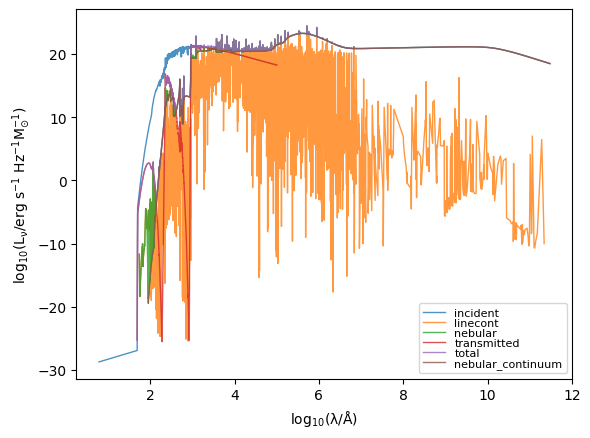

In [8]:
for spectra_id in grid.available_spectra:
    # Get `Sed` object
    sed = grid.get_spectra(grid_point, spectra_id=spectra_id)

    # Mask zero valued elements
    mask = sed.lnu > 0
    plt.plot(
        np.log10(sed.lam[mask]),
        np.log10(sed.lnu[mask]),
        lw=1,
        alpha=0.8,
        label=spectra_id,
    )

plt.legend(fontsize=8, labelspacing=0.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")

## Plot ionising luminosities

We can also plot properties over the entire age and metallicity grid, such as the ionising luminosity. 

In the examples below we plot ionising luminosities for HI and HeII

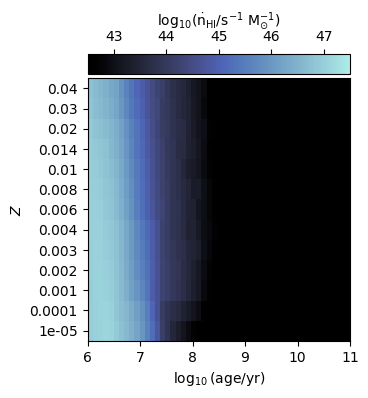

In [9]:
fig, ax = grid.plot_specific_ionising_lum(ion="HI")

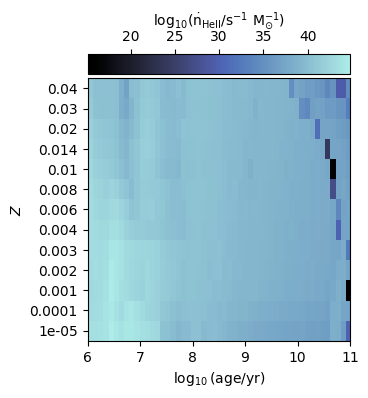

In [10]:
fig, ax = grid.plot_specific_ionising_lum(ion="HeII")

## Resampling Grids

If you want to resample a grid after instantiation, you can apply the `intrep_spectra` method:

In [11]:
# Define a new set of wavelengths
new_lams = np.logspace(2, 5, 10000)

print("The old grid had dimensions:", grid.spectra["incident"].shape)

# Get the grid interpolated onto the new wavelength array
grid.interp_spectra(new_lam=new_lams)

print("The interpolated grid has dimensions:", grid.spectra["incident"].shape)

The old grid had dimensions: (51, 13, 9244)


The interpolated grid has dimensions: (51, 13, 10000)


Note that this will overwrite the spectra and wavelengths read from the file *in place*.
To get back to the original arrays, a separate `Grid` can be instatiated without the modified wavelength array.

## Converting a `Grid` into an `Sed`

Any of the spectra arrays stored within a `Grid` can be returned as `Sed` objects (see the `Sed` [docs](../sed/sed.rst)). This enables all of the analysis methods provide on an Sed to be used on the whole spectra grid. To do this we simply call `get_sed` with the spectra type we want to extract, and then use any of the included methods.

In [12]:
# Get the sed object
sed = grid.get_sed(spectra_type="incident")

# Measure the balmer break for all spectra in the grid (limiting the output)
sed.measure_balmer_break()[5:10, 5:10]

array([[0.99095578, 1.00851607, 1.00394175, 0.99979438, 0.94348793],
       [1.01696748, 1.01627346, 1.0026636 , 0.97766383, 0.97755911],
       [1.04712358, 1.03816692, 1.02788439, 1.0014771 , 0.9827252 ],
       [1.12597668, 1.08081315, 1.05479005, 1.02042145, 1.01481675],
       [1.09623435, 1.06834097, 1.05297887, 1.04633496, 1.03886266]])